In [1]:
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

dataPath = '../PedestrianData/IntentionData'
pd.__version__

'0.24.2'

#### Loading the demographic and environmental data from pickle:

In [2]:
data = pd.read_pickle('../PedestrianData/Rafael.pkl')
pd.options.display.max_columns = None
data.sample(1)

,File,Scenario,Wait Time (s),PET (s),Distace to Collision Point,Card ID,Speed Limit,Lane Width,Minimum Gap,Mean Arrival Rate,AV,Full Braking Before Impact_-1.0,Full Braking Before Impact_1,Full Braking Before Impact_2,Full Braking Before Impact_3,Snowy,One way,two way,Two way with median,Night,name,numcars,Vrexpnum,Age_9-12,Age_15-18,Age_12-15,Age_18 - 24,Age_25 - 29,Age_30 - 39,Age_40 - 49,Age_50 - 59,Age_60+,Gender_Female,Occupation_Employed,Occupation_Student,Occupation_Unemployed,Occupation_kid,Education_Bachelors degree,Education_College/University student,Education_Doctorate degree,Education_High school diploma,Education_Masters degree,Education_Professional degree,driving license_Yes,mode_Bike,mode_Car,mode_Public Transit,mode_Walking,workwalk_No,workwalk_Sometimes,workwalk_Yes,shopwalk_No,shopwalk_Sometimes,shopwalk_Yes,shopwalk_kid,Vrexp_Yes,Heart_Currently,Heart_Over the years,vision_Currently,vision_Over the years,anxiety_Currently,anxiety_Over the years,Headaches_Currently,Headaches_Over the years,dizziness_Over the years
3228,shabari/16--2018-09-5--17-21-20.txt,16,12.3835,1000,7.4,16,40,3,1.5,530,100,0,0,1,0,1,1,0,0,0,shabari,2,NaN,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


#### Removing folder names from file values (some files are in subfolders)
#### Cleasing data that contain errors

In [3]:
for i in range(len(data)):
    value = data['File'].values[i].split('/')
    data['File'].values[i] = value[len(value) - 1]
    data['Wait Time (s)'] == "Err2"
    
data = data[data['Wait Time (s)'] != "Err1"]
data = data[data['Wait Time (s)'] != "Err2"]
data = data[data['Wait Time (s)'] != "Err3"]
data = data[data['Wait Time (s)'] != "Err4"]
data = data[data['Wait Time (s)'] != "Err5"]
data = data[data['Wait Time (s)'] != 0]
    
data.shape

(3410, 65)

## Curating final set of possible features

In [4]:
files = os.listdir(dataPath)

features = np.empty((len(files), 22), dtype=list)

for i in range(len(files)):
    file = dataPath + "/" + files[i]
    df = pd.read_csv(file, sep=",", header=None, 
                 names=["Time", 
                        "Pos_x", "Pos_y", "Pos_z", 
                        "Gaz_x", "Gaz_y", "Gaz_z", 
                        "Vel_x", "Vel_z",
                        "Acc_x", "Acc_z",
                        "Vel_Mag", "Acc_Mag",
                        "Vel_Ang", "Acc_Ang", "Gaz_Ang",
                        "Vel_Bin", "Acc_Bin", "Gaz_Bin", "Chg_Bin"          
                       ])
    
    try:
        features[i, 0] = (data.loc[data['File'] == files[i]])["Wait Time (s)"].item()
        features[i, 1] = (data.loc[data['File'] == files[i]])["Lane Width"].item()
        features[i, 2] = (data.loc[data['File'] == files[i]])["One way"].item()
        features[i, 3] = (data.loc[data['File'] == files[i]])["Snowy"].item()
        features[i, 4] = (data.loc[data['File'] == files[i]])["Night"].item()
        features[i, 5] = (data.loc[data['File'] == files[i]])["Speed Limit"].item()
        features[i, 6] = (data.loc[data['File'] == files[i]])["Mean Arrival Rate"].item()
    except:
        features[i, 0] = 0
        features[i, 1] = 0
        features[i, 2] = 0
        features[i, 3] = 0
        features[i, 4] = 0
        features[i, 5] = 0
        features[i, 6] = 0
    finally:
        # Filling the rest of the features with each direction bin
        gaze_bins = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0]
        change_bins = np.histogram(np.array(df["Chg_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0]
        for j in range(len(gaze_bins)):
            features[i, j+7] = gaze_bins[j]
        for k in range(len(change_bins)):
            features[i, k+j+7] = change_bins[k]
            
# Removing data with crossing time of '0'
features = features[features[:, 0] != 0]

In [14]:
features 

array([[11.39143, 2.75, 0.0, ..., 1, None, None],
       [14.03475, 2.75, 0.0, ..., 0, None, None],
       [14.8416, 2.75, 0.0, ..., 4, None, None],
       ...,
       [8.032308, 2.75, 0.0, ..., 9, None, None],
       [9.176275, 2.75, 0.0, ..., 2, None, None],
       [11.65396, 2.75, 0.0, ..., 5, None, None]], dtype=object)

# Testing regression models

In [12]:
def getData(N):
    x,y =[],[]
    for i in range(N):
        c = [
            
            features[i,1], # Lane width (2, 2.5, 3)
            features[i,2], # One Way (0, 1)
            features[i,3], # Snowy (0, 1)
            features[i,4], # Night (0, 1)
            features[i,5], # Speed Limit (30, 40, 50)
            features[i,6], # Mean Arrival
            # head pose bins
            features[i,7], features[i,8], features[i,9], features[i,10], features[i,11], features[i,12], features[i,13], 
            # change pose bins
            #features[i,14], features[i,15], features[i,16], features[i,17], features[i,18], features[i,19]
            
        ]
        yy = features[i, 0]
        x.append(c)
        y.append(yy)
    return np.array(x), np.array(y)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

def evaluate_mse(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = np.sqrt(mean_squared_error(y_test, predictions))
    print('Model Performance')
    print('MSE of: ', errors)
    
    return errors
    
X,y=getData(len(features))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
print(X_train.shape)
print(y_train.shape)
X_train.dtype

(1174, 13)
(1174,)


dtype('float64')

In [36]:
print(X_train.shape)
print(y_train.shape)
X_train.dtype
np.unique([str(datum.dtype) for datum in features[:,1]])

(1174, 13)
(1174,)


AttributeError: 'float' object has no attribute 'dtype'

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished
C:\Users\Rafael\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [29]:
print(rf_random.best_params_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}


In [38]:
base_model = RandomForestRegressor(bootstrap = True, n_estimators = 100)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
base_mse = evaluate_mse(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
random_mse = evaluate_mse(best_random, X_test, y_test)

print('\n')
print('Accuracy Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
print('MSE Improvement of {:0.2f}%.'.format(-100 * (random_mse - base_mse) / base_mse))

Model Performance
Average Error: 3.0621 degrees.
Accuracy = 81.99%.
Model Performance
MSE of:  5.755589138398937
Model Performance
Average Error: 3.0068 degrees.
Accuracy = 82.40%.
Model Performance
MSE of:  5.616809676983853


Accuracy Improvement of 0.49%.
MSE Improvement of 2.41%.


In [31]:
forest_reg = rf_random.best_estimator_
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)  

print('R^2:', metrics.r2_score(y_test,y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

scores = cross_val_score(forest_reg, X, y, cv=10)
display_scores(scores)

x_ax=range(len(y_pred))
plt.figure(figsize=(20, 10)) 
plt.scatter(x_ax, y_test, s=5, color="green", label="original")
plt.scatter(x_ax, y_pred, s=5, color="red", label="predicted")
    
plt.xlabel("Trial #")
plt.ylabel("Time of Cross (s)")
plt.legend()
plt.show()

NameError: name 'rf_random' is not defined

In [19]:

from dbn.tensorflow import SupervisedDBNRegression
# Training
regressor = SupervisedDBNRegression(hidden_layers_structure=[100],
                                    learning_rate_rbm=0.01,
                                    learning_rate=0.01,
                                    n_epochs_rbm=20,
                                    n_iter_backprop=200,
                                    batch_size=16,
                                    activation_function='relu')
regressor.fit(X_train, y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 94936174309366.562500
>> Epoch 2 finished 	RBM Reconstruction error 112726286074821.750000
>> Epoch 3 finished 	RBM Reconstruction error 91363288692093.625000
>> Epoch 4 finished 	RBM Reconstruction error 98775054571684.609375
>> Epoch 5 finished 	RBM Reconstruction error 107875034495918.703125
>> Epoch 6 finished 	RBM Reconstruction error 85931213038025.734375
>> Epoch 7 finished 	RBM Reconstruction error 82632691726962.859375
>> Epoch 8 finished 	RBM Reconstruction error 97621635649013.718750
>> Epoch 9 finished 	RBM Reconstruction error 101799952005274.046875
>> Epoch 10 finished 	RBM Reconstruction error 83870807677451.593750
>> Epoch 11 finished 	RBM Reconstruction error 89312313269159.828125
>> Epoch 12 finished 	RBM Reconstruction error 131140743738070.890625
>> Epoch 13 finished 	RBM Reconstruction error 104962825247358.875000
>> Epoch 14 finished 	RBM Reconstruction error 95033037151846.937500
>> Epoch 15

>> Epoch 132 finished 	ANN training loss 132.659210
>> Epoch 133 finished 	ANN training loss 132.677505
>> Epoch 134 finished 	ANN training loss 132.677917
>> Epoch 135 finished 	ANN training loss 132.669189
>> Epoch 136 finished 	ANN training loss 132.664734
>> Epoch 137 finished 	ANN training loss 132.661926
>> Epoch 138 finished 	ANN training loss 132.700607
>> Epoch 139 finished 	ANN training loss 132.691620
>> Epoch 140 finished 	ANN training loss 132.660248
>> Epoch 141 finished 	ANN training loss 132.658783
>> Epoch 142 finished 	ANN training loss 132.659332
>> Epoch 143 finished 	ANN training loss 132.682022
>> Epoch 144 finished 	ANN training loss 132.679169
>> Epoch 145 finished 	ANN training loss 132.659698
>> Epoch 146 finished 	ANN training loss 132.669220
>> Epoch 147 finished 	ANN training loss 132.686386
>> Epoch 148 finished 	ANN training loss 132.691895
>> Epoch 149 finished 	ANN training loss 132.659882
>> Epoch 150 finished 	ANN training loss 132.693954
>> Epoch 151

SupervisedDBNRegression(batch_size=16, dropout_p=0, l2_regularization=1.0,
                        learning_rate=0.01, n_iter_backprop=200, verbose=True)

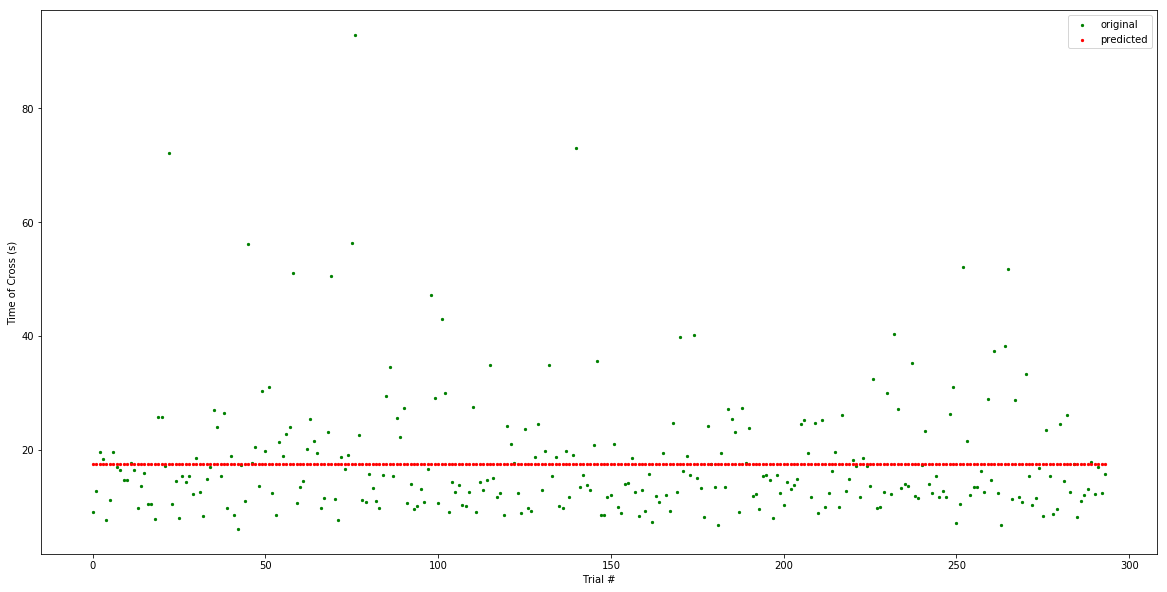

R^2: -0.002135972367997674
Mean Absolute Error: 7.137601684377658
Mean Squared Error: 119.9394967413633
Root Mean Squared Error: 10.951689218625742


In [20]:
from sklearn.metrics.regression import r2_score, mean_squared_error
y_pred = regressor.predict(X_test)

x_ax=range(len(y_pred))
plt.figure(figsize=(20, 10)) 
plt.scatter(x_ax, y_test, s=5, color="green", label="original")
plt.scatter(x_ax, y_pred, s=5, color="red", label="predicted")
    
plt.xlabel("Trial #")
plt.ylabel("Time of Cross (s)")
plt.legend()
plt.show()

print('R^2:', metrics.r2_score(y_test,y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [28]:
X_test.shape

(294, 13)